### Data Scientist Nanodegree
### CRISP-DM Process
### Project: CRISP-DM_Seattle AirBNB

### Objective:

Using CRISP-DM process find answers to some interesting that can be helpful in business point of view. Using the  
[Seattle AirBNB Data](https://www.kaggle.com/airbnb/seattle/data) to find answers to those questions.

#### CRISP-DM (Cross Industry Process for Data Mining) 

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deploy

### 1. Business Understanding

- **Ques 1:** Most important feature affecting rental price ?
- **Ques 2:** Top three neighbourhoods having highest rental price ?
- **Ques 3:** Top three months having the highest rental price ?

### 2. Data Understanding

In [59]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm

import re
from datetime import datetime
import warnings; warnings.simplefilter('ignore')

#### Gather data

In [4]:
df_calendar = pd.read_csv("calendar.csv", )
df_listings = pd.read_csv("listings.csv")

#### Access data

#### 2.1 calender data set

In [29]:
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [5]:
df_calendar.shape

(1393570, 4)

In [6]:
# check availabily values
df_calendar['available'].value_counts()

t    934542
f    459028
Name: available, dtype: int64

In [7]:
# check relationship of listing price with availablility = 'f'
df_calendar[df_calendar['price'].isnull()]['available'].value_counts()

f    459028
Name: available, dtype: int64

In [8]:
# check relationship of listing price with availablility = 't'
df_calendar[df_calendar['price'].notnull()]['available'].value_counts()

t    934542
Name: available, dtype: int64

In [9]:
df_calendar[df_calendar['price'].notnull & df_calendar['price'].str.contains(',')]['price'].value_counts()

$1,000.00    370
$1,099.00    120
$1,650.00     91
$1,199.00     71
$1,450.00     28
$1,250.00     15
$1,240.00      2
Name: price, dtype: int64

##### Note:
listing_id: is numeric
date:       object type
available:  values ['t','f'] can be considered as True or False.
price:      listing price on respective date if 'available' is 't'.

##### Data issues 

1. date: Convert date into date type. Will be helpful for further analysis.
2. available: values ['t','f'] can be considered into [0,1] respectively.
3. price values contains '$' and ',' that can be removed and then convert the price into float type.  

#### 2.2 Listings date set

In [10]:
df_listings.shape

(3818, 92)

In [11]:
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 50)
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [12]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [13]:
df_listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [14]:
# Investigate patterns in the amount of missing data in each column.
features = df_listings.columns
percent_missing = round(df_listings.isnull().mean()*100,0).astype(int)
missing_value_df = pd.DataFrame.from_dict({'Feature': features,
                                 'percent_missing': percent_missing})

In [15]:
missing_value_df[missing_value_df['percent_missing'] != 0].sort_values(by=['percent_missing'], ascending=False)

,Feature,percent_missing
license,license,100
square_feet,square_feet,97
monthly_price,monthly_price,60
security_deposit,security_deposit,51
weekly_price,weekly_price,47
notes,notes,42
cleaning_fee,cleaning_fee,27
neighborhood_overview,neighborhood_overview,27
transit,transit,24
host_about,host_about,22


##### Data issue in listings data set

**Note:** 
1. Here so much of rough work is done in order to find details of these feature (like finding the number of missing rows, finding the unique values in a feature) but the **rough code is not shown here**.
2. **Consider droping features having missing values 15% or above.** 


- **id:** this is the listing id and can be mapped with listing_id in calender date set. Convert 'id' into string.
- **listing_url:** no missing values but unnecessary feature. Can be dropped.
- **scrape_id:** drop this fetaure. It seems unnecessary for further analysis.
- **last_scraped:** date format 'YYYY-MM-DD'. keep as it is for now.
- **name:** keep as it is.
- **summary:** keep as it is.
- **space:** unnecessary feature can be dropped.
- **description:** keep as it is.
- **experiences_offered:** drop as this feature has only one value 'none'.
- **neighborhood_overview:** neighbourhood description, drop as it has 27% missing.
- **notes:** 42% values are missing. Drop this feature,
- **transit:** description of neighbourhood and facilities provided. It's a mixed description and 24% values are missing that's why drop it.
- **picture_url, thumbnail_url, medium_url and xl_picture_url:** picture_url, thumbnail_url, medium_url and xl_picture_url looks same image but in different sizes. The availability of value is not same. These features can be useful if we convert it into [0,1]. 1 if value is available else 0. 
- **host_id:** host with multiple listing_id. Convert it into string. 
- **host_url:** looks it is the url to host profile page. Can be dropped.
- **host_name:** This is the first name of host. But we can drop this feature as first name is not a unique identity for unique identity we already have host_id.
- **host_since:** Date when the host create his/her profile on listing website. This feature will be more useful if we convert it into the number of days between host_since (date) and today date.
- **host_location:** The format of the information is "city, state, country" but the format is not consistant. It needs to be fixed and also have 0.2% of missing values. unecessary feature drop it.
- **host_about:** drop this feature as it is having 22% missing values.
- **host_response_time:** the response time of host is a categorical and can be encode as below
                            {   1: "within an hour",
                                2: "within a few hours",
                                3: "within a day",
                                4: "a few days or more"}
                         but there are 14% can be encoded as 4 ("a few days or more").
- **host_response_rate:** is in percentage between minimum 38% and maximum 100%. Here we can convert this feature into floatby removing '%' sign.
- **host_acceptance_rate:** The meaning of this feature is not clear by it's values (80% values as '100%' except one that is 0%) and remaining 20% are missing values. drop this feature.
- **host_is_superhost:** if a host is rated as superhost by the quest or not (values ['t',f']). Having 0.05% missing values. Can be converted as 'f'/NaN ==> 0 and 't' == 1.
- **host_thumbnail_url:** image url for host in thumbnail size. Can be dropped.
- **host_picture_url:** this feature seems the same images as host_thumbnail_url. We can drop this feature.
- **host_neighbourhood:** categorical feature with 8% missing value through out the host_id. Mean if value is missing then it is missing for listings for that host_id. Drop missing rows.
- **host_listings_count:** counts of listings for each host_id
- **host_total_listings_count:** same values as in host_listings_count. Can drop this feature.
- **host_verifications:** each value is a list of verification type. All the uniques verification type can be converted new feature and mark them 1.
- **host_has_profile_pic:** indicator for host profile picture 't'/'f'.
- **host_identity_verified:** indicator if host identity is verified 't'/'f'.
- **street:** street address seems not useful. Can be dropped. 
- **neighbourhood:** neighbourhood name with 11% missing value. how to fix these missing value is not clear as if we impute these rows with some values may be that will not match with the street address. Seems that the next feature "neighbourhood_cleansed" is a replacement for "neighbourhood". Can be dropped.
- **neighbourhood_cleansed:** can be useful as it has no missing values. And it seems that neighbourhood feature is cleaned. neighbourhood_group_cleansed seems to be rollup level for this feature. Keep it as it is.
- **neighbourhood_group_cleansed:** This feature seems to be the rollup level for "neighbourhood_cleansed" with no missing values and divided into few group of neighbourhood. Using this feature will be far better as it has few unique values. 
- **city:** city names with no missing values. Just one value "西雅图" in chinese language that translates to "Seattle". Can be fixed.
- **state:** has only two values "WA" and "wa" for "Washington". As it has only "Washington" has unique value, we can drop this feature. 
- **zipcode:** zipcode seem ok just one incorrect value "99\n98122", can be converted to "98122". This is categorical type with 7 missing value can drop these rows. But this feature is unnecessary can be dropped.
- **market:**  has only one unique value "Seattle". Can be dropped.
- **smart_location:** format is district, city, state. Can be dropped.
- **country_code:** has only one unique value "US". Can be dropped.
- **country:** has only one unique value "United States". Can be dropped.
- **latitude:** values look ok but this feature is not useful until we try to pin point the location on map. Can be dropped.
- **longitude:** values look ok but this feature is not useful until we try to pin point the location on map. Can be dropped.
- **is_location_exact:** indicator ['t','f'], if the location is correct. Not useful can be dropped. 
- **property_type:** Good feature with limited unique values and have a missing value this rows can be dropped.
- **room_type:** This seems to be a good feature with limited unique values.
- **accommodates:** allowed number of person sharing. 
- **bathrooms:** number of bathrooms in house. 16 missing values can be encoded as 0.
- **bedrooms:** number of bedrooms in house. 6 missing values can be encoded as 0.
- **beds:** number of beds in room. 1 missing values can be encoded as 1.
- **bed_type:** Good feature with limited unique values and no missing value
- **amenities:** Descriptive text, Can be useful for further analysis. Encode into One-Hot key.
- **square_feet:** measure of area in square feet with 97% missing values. Drop this feature.
- **price:** price in string format. Remove "\$" and ",". And convert into int/float. 
- **weekly_price:** price for a week in string format with 47% missing value. Drop this feature.
- **monthly_price:** monthly price similar as weekly_price with 60% missing value. Drop this feature.
- **security_deposit:** 51% missing values. Drop this feature.
- **cleaning_fee:** 27% missing values. Drop this feature.
- **guests_included:** number of guests.
- **extra_people:** charges in dollar applicable for each extra person. Remove '$' and convert into int/float.
- **minimum_nights:** minimum number of nights for stay.
- **maximum_nights:** maximum number of nights for stay.
- **calendar_updated:** this feature is a categorical and this can be converted as 1 if calendar_updated 'today' else 0.
- **has_availability:** this feature has only one value. Drop this feature.
- **availability_30:** unnecessary feature can be dropped. 
- **availability_60:** unnecessary feature can be dropped.
- **availability_90:** unnecessary feature can be dropped.
- **availability_365:** unnecessary feature can be dropped.
- **calendar_last_scraped:** this feature has only one value. Can be dropped.
- **number_of_reviews:** unnecessary feature can be dropped.
- **first_review:** first review date. Unnecessary feature can be dropped.
- **last_review:** last review date. unnecessary feature can be dropped.
- **review_scores_rating:** scale of 100 with 17% missing values. Can be dropped.
- **review_scores_accuracy:** scale of 10 with 17% missing values. Can be dropped.
- **review_scores_cleanliness:** scale of 10 with 17% missing values. Can be dropped.
- **review_scores_checkin:** scale of 10 with 17% missing values. Can be dropped.
- **review_scores_communication:** scale of 10 with 17% missing values. Can be dropped.
- **review_scores_location:** scale of 10 with 17% missing values. Can be dropped.
- **review_scores_value:** scale of 10 with 17% missing values. Can be dropped.
- **requires_license:** this feature has only one value 'f'. Can be dropped.
- **license:** 100% missing values. Drop this feature.
- **jurisdiction_names:** has only one value "WASHINGTON". Can be dropped.
- **instant_bookable:** has two values ['f', 't']. Can be encoded [0, 1].
- **cancellation_policy:** has three values ['flexible', 'moderate', 'strict']. Keep as it is.
- **require_guest_profile_picture:** has two values ['f', 't'] can be encoded as [0, 1]
- **require_guest_phone_verification:** has two values ['f', 't'] can be encoded as [0, 1]
- **calculated_host_listings_count:** number of host listings.
- **reviews_per_month:** number of review per month. Unnecessary feature can be dropped.

### 3. Data Preparation

#### 3.1 calender dataset: clean the data and prepare it for further analysis by applying following steps:
* The 'Price' in dataset "calender" contains '$' and ','. Remove these characters and convert it to datatype float.
* Feature 'available' has values 't' and 'f'. Can be converted into [1,0].
* For further analysis, create new features 'day-of-week', 'month' and 'year' using feature 'date'. 

In [7]:
def clean_calender(df_cal):

    df = df_cal.copy()

    df['price'] = df['price'].str.lstrip('$').str.replace(',','')
    df['price'] = df['price'].fillna(0.00).astype(float)
    df['available'] = df['available'].apply(lambda x: 1 if x == 't' else 0).astype('int32')

    # Engineer Feature day-of-week, month, year 
    look_up = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',
               6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    
    df['date'] = pd.to_datetime(df['date'])
    df['day-of-week'] = df['date'].dt.weekday_name
    df['month'] = df['date'].dt.month.apply(lambda x: look_up[x])
    df['year'] = df['date'].dt.year
    
    return df


In [8]:
#df_calendar_copy = df_calendar.copy()
df_calendar_clean = clean_calender(df_calendar)
df_calendar_clean.head()

,listing_id,date,available,price,day-of-week,month,year
0,241032,2016-01-04,1,85.0,Monday,Jan,2016
1,241032,2016-01-05,1,85.0,Tuesday,Jan,2016
2,241032,2016-01-06,0,0.0,Wednesday,Jan,2016
3,241032,2016-01-07,0,0.0,Thursday,Jan,2016
4,241032,2016-01-08,0,0.0,Friday,Jan,2016


In [9]:
# save clean calendar data set to pickle file
df_calendar_clean.to_pickle('calendar_clean.pkl')

#### 3.2 listings dataset: clean the data and prepare it for further analysis by applying following steps:

##### 3.2.1 handle missing values
* Drop features having 15% or above missing values.
     - space, 
     - neighborhood_overview
     - notes
     - transit
     - host_about
     - host_acceptance_rate
     - square_feet
     - weekly_price
     - monthly_price
     - security_deposit
     - cleaning_fee
     - first_review
     - last_review
     - review_scores_rating
     - review_scores_accuracy
     - review_scores_cleanliness
     - review_scores_checkin
     - review_scores_communication
     - review_scores_location
     - review_scores_value
     - license
     - reviews_per_month
     
* Drop other unnecessary features includes:
    - listing_url
    - scrape_id
    - summary
    - space
    - experiences_offered
    - host_url
    - host_name
    - host_picture_url
    - host_location
    - host_thumbnail_url
    - host_total_listings_count
    - street
    - neighbourhood
    - state
    - zipcode
    - market
    - smart_location
    - country_code
    - country
    - latitude
    - longitude
    - is_location_exact
    - has_availability
    - availability_30
    - availability_60
    - availability_90
    - availability_365
    - calendar_last_scraped
    - number_of_reviews
    - requires_license
    - jurisdiction_names

* Drop row for missing values for the follow features:
    - host_neighbourhood
    - host_response_rate
    - host_response_time
    - property_type


In [324]:
# features having 15% or above missing values
missing_value_df[missing_value_df['percent_missing'] >= 15]['Feature'].unique()

array(['space', 'neighborhood_overview', 'notes', 'transit', 'host_about',
       'host_acceptance_rate', 'square_feet', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'license',
       'reviews_per_month'], dtype=object)

In [325]:
# Drop feature with more than 14% missing values
df_listings_reduced = df_listings.loc[:, df_listings.isnull().mean() < .15].copy()

In [328]:
# Drop features 'experiences_offered' is all 'none' and 'summary' seems not useful not useful.
df_listings_reduced = df_listings_reduced.drop(['last_scraped','listing_url','scrape_id', 'summary', 'space', 
                                                'experiences_offered',
                                                'host_url', 'host_name', 'host_location','host_picture_url', 
                                                'host_thumbnail_url',
                                                'host_total_listings_count', 'street', 'neighbourhood', 'state',
                                                'zipcode', 'market', 'smart_location', 'country_code', 'country',
                                                'latitude', 'longitude', 'is_location_exact', 'has_availability',
                                                'availability_30', 'availability_60',
                                                'availability_90', 'availability_365', 'calendar_last_scraped',
                                                'number_of_reviews', 'requires_license', 'jurisdiction_names'], axis=1)

In [329]:
df_listings_reduced['missing_values_count'] = df_listings_reduced.isnull().sum(axis=1)
df_listings_reduced[df_listings_reduced['missing_values_count'] > 10].shape[0]

0

* There is no rows having more than 10 missing values. 

In [330]:
# check the remaining features with missing values 
df_listings_reduced[df_listings_reduced['missing_values_count'] != 0].sort_values(by=['missing_values_count'],\
                                                                                  ascending=False)

,id,name,description,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,city,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,missing_values_count
1419,10235014,Luxury Apartment in Belltown / SLU,Beautiful building near the heart of downtown ...,https://a2.muscache.com/ac/pictures/2644576c-4...,https://a2.muscache.com/im/pictures/2644576c-4...,https://a2.muscache.com/ac/pictures/2644576c-4...,https://a2.muscache.com/ac/pictures/2644576c-4...,1075031,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,Belltown,Downtown,Seattle,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$250.00,1,$0.00,1,1125,a week ago,f,flexible,f,f,1,8
1297,8354452,The View | Be Inspired in Seattle,A studio with stunning waterfront view worth t...,https://a2.muscache.com/ac/pictures/6d46a5de-9...,https://a2.muscache.com/im/pictures/6d46a5de-9...,https://a2.muscache.com/ac/pictures/6d46a5de-9...,https://a2.muscache.com/ac/pictures/6d46a5de-9...,42515980,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,Belltown,Downtown,Seattle,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$99.00,1,$25.00,2,13,2 months ago,f,moderate,f,f,1,8
2671,9774404,Bohemian Studio in Capitol Hill,Beautifully designed studio with hardwood floo...,NaN,NaN,https://a2.muscache.com/ac/pictures/298c8a8f-3...,NaN,18746557,2014-07-23,NaN,NaN,f,NaN,1.0,"['phone', 'facebook']",t,f,Broadway,Capitol Hill,Seattle,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{""Wireless Internet"",Kitchen,""Smoking Allowed""...",$100.00,1,$0.00,1,1125,5 weeks ago,f,flexible,f,f,1,6
2943,9094872,Funky Apartment - Historic Building,In the heart of Capitol Hill with easy access ...,NaN,NaN,https://a2.muscache.com/ac/pictures/b7b15917-d...,NaN,9016477,2013-09-23,NaN,NaN,f,NaN,1.0,"['email', 'phone', 'reviews']",t,f,Broadway,Capitol Hill,Seattle,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,{},$99.00,1,$0.00,20,1125,2 months ago,f,flexible,f,f,1,6
2584,6646894,Retro Capitol Hill Apartment,"Huge studio on Capitol Hill, in the heart of S...",NaN,NaN,https://a0.muscache.com/ac/pictures/97764860/4...,NaN,34596895,2015-05-30,NaN,NaN,f,NaN,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,Broadway,Capitol Hill,Seattle,Apartment,Entire home/apt,3,1.0,0.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Wheelchair A...",$175.00,2,$20.00,1,1125,5 months ago,f,moderate,f,f,1,6
375,7322718,Greenlake bungalow,"Three bedrooms, 1 bath, chef's kitchen and won...",NaN,NaN,https://a1.muscache.com/ac/pictures/92906685/1...,NaN,38360428,2015-07-13,NaN,NaN,f,Wallingford,1.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,Wallingford,Other neighborhoods,Seattle,House,Entire home/apt,5,1.0,3.0,3.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Free Pa...",$249.00,1,$0.00,4,1125,4 months ago,f,strict,f,f,1,5
1800,6436772,Spacious 4 BR/2.5 BA Family Home,"2,200 sq.ft. 4 bed/2.5 bath ranch home. Spacio...",NaN,NaN,https://a0.muscache.com/ac/pictures/94124806/0...,NaN,33601572,2015-05-17,NaN,NaN,f,North Admiral,1.0,"['email', 'reviews', 'jumio']",t,f,North Admiral,West Seattle,Seattle,House,Entire home/apt,8,3.0,4.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",$350.00,6,$25.00,3,15,3 days ago,f,strict,f,f,1,5
283,5336585,Beautiful Loft Apartment UW,I have a great loft apartment in the Wallingfo...,NaN,NaN,https://a0.muscache.com/ac/pictures/66669754/7...,NaN,27656377,2015-02-12,NaN,NaN,f,Wallingford,1.0,"['email', 'phone', 'facebook', 'r

In [331]:
num_missing_value = df_listings_reduced['missing_values_count'].sum()
total_values =  df_listings_reduced.shape[0]*df_listings_reduced.shape[1]
print('Percentage of data still missing: {}'.format((num_missing_value/total_values)*100))


Percentage of data still missing: 1.5322158198009428


In [332]:
features = df_listings_reduced.columns
percent_missing = round(df_listings_reduced.isnull().mean()*100,3).astype(float)
missing_value_df2 = pd.DataFrame.from_dict({'Feature': features,
                                 'percent_missing': percent_missing})

In [334]:
# check how much data is still missing in each feature
missing_value_df2[missing_value_df2['percent_missing'] > 0.0].sort_values(by=['percent_missing'], ascending=False)

,Feature,percent_missing
host_response_time,host_response_time,13.698
host_response_rate,host_response_rate,13.698
thumbnail_url,thumbnail_url,8.381
medium_url,medium_url,8.381
xl_picture_url,xl_picture_url,8.381
host_neighbourhood,host_neighbourhood,7.858
bathrooms,bathrooms,0.419
bedrooms,bedrooms,0.157
host_since,host_since,0.052
host_is_superhost,host_is_superhost,0.052


In [335]:
# drop rows having missing values for host_response_time, host_response_rate and host_neighbourhood and property_type
df_listings_reduced = df_listings_reduced.dropna(axis=0, subset=['host_neighbourhood','host_response_rate',\
                                                                 'host_response_time', 'property_type'])

In [337]:
# number of still missing values in each feature
df_listings_reduced.isnull().sum()

id                                    0
name                                  0
description                           0
thumbnail_url                       247
medium_url                          247
picture_url                           0
xl_picture_url                      247
host_id                               0
host_since                            0
host_response_time                    0
host_response_rate                    0
host_is_superhost                     0
host_neighbourhood                    0
host_listings_count                   0
host_verifications                    0
host_has_profile_pic                  0
host_identity_verified                0
neighbourhood_cleansed                0
neighbourhood_group_cleansed          0
city                                  0
property_type                         0
room_type                             0
accommodates                          0
bathrooms                            14
bedrooms                              6


* other missing values will be fixed when when we will encode those columns 

##### 3.2.2  Features cleansing and encoding

- **picture_url, thumbnail_url, medium_url and xl_picture_url:** picture_url, thumbnail_url, medium_url and xl_picture_url looks same image but in different sizes. The availability of value is not same. These features can be useful if we convert it into [0,1]. 1 if value is available else 0.
- **host_since:** This feature will be more useful if we convert it into the number of days between host_since (date) and today date.
- **host_response_time:** the response time of host is a categorical and can be encode as below
                            {   1: "within an hour",
                                2: "within a few hours",
                                3: "within a day",
                                4: "a few days or more"}
                         but there are 14% can be encoded as 4 ("a few days or more").
- **host_response_rate:** is in percentage between minimum 38% and maximum 100%. Here we can convert this feature into float by removing '%' sign.
- **host_is_superhost:** if a host is rated as superhost by the quest or not (values ['t',f']). Having 0.05% missing values. Can be converted as 'f'/NaN ==> 0 and 't' == 1.
- **host_verifications:** each value is a list of verification type. All the uniques verification type can be converted new feature and mark them 1.
- **city:** city names with no missing values. Just one value "西雅图" in chinese language that translates to "Seattle". Can be fixed. Row dropped alread.
- **amenities:** Descriptive text, Can be useful for further analysis. convert into dummy variables.
- **bathrooms:** number of bathrooms in house. 16 missing values can be imputed as 1.
- **bedrooms:** number of bedrooms in house. 6 missing values can be imputed as 1.
- **beds:** number of beds in room. 1 missing values can be imputed as 1.
- **price:** price in string format. Remove "\$" and ",". And convert into int/float. 
- **calendar_updated:** this feature is a categorical and this can be converted as 1 if calendar_updated 'today' else 0.
- **instant_bookable:** has two values ['f', 't']. Can be encoded [0, 1].
- **require_guest_profile_picture:** has two values ['f', 't'] can be encoded as [0, 1]
- **require_guest_phone_verification:** has two values ['f', 't'] can be encoded as [0, 1]


In [427]:
# encode 'thumbnail_url', 'medium_url','xl_picture_url' as available and not available
df_listings_reduced[['picture_url','thumbnail_url', 'medium_url','xl_picture_url']] =\
np.where(df_listings_reduced[['picture_url','thumbnail_url', 'medium_url','xl_picture_url']].isnull(), 0, 1).astype('int32')

In [428]:
df_listings_reduced[['picture_url','thumbnail_url', 'medium_url','xl_picture_url']].head()

,picture_url,thumbnail_url,medium_url,xl_picture_url
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
4,1,1,1,1
6,1,1,1,1


In [355]:
assert(df_listings_reduced['thumbnail_url'].isnull().sum() == 0)

In [356]:
assert(df_listings_reduced['medium_url'].isnull().sum() == 0)

In [357]:
assert(df_listings_reduced['xl_picture_url'].isnull().sum() == 0)

In [41]:
from datetime import datetime

def get_date_diff(d0, d1):
    '''
        INPUT
        d0, d1 - Start date and End dates
        
        OUTPUT
        Difference between dates in number of days
    '''
    
    date_format = "%Y-%m-%d"
    d0 = datetime.strptime(d0, date_format)
    d1 = datetime.strptime(d1, date_format)

    delta = d1 - d0
    return (delta.days)

get_date_diff('2016-01-04', '2017-01-05')

367

In [434]:
# Convert ['host_since'] in to number of days
date_format = "%Y-%m-%d"
now = datetime.now()
now = now.strftime('%Y-%m-%d')

df_listings_reduced['host_since'] = df_listings_reduced['host_since'].apply(lambda x: get_date_diff(str(x), now))

In [358]:
# unique values in host_response_time
df_listings_reduced['host_response_time'].unique()

array(['within a few hours', 'within an hour', 'within a day',
       'a few days or more'], dtype=object)

In [359]:
# encode host_response_time
df_listings_reduced['host_response_time'] = df_listings_reduced['host_response_time'].replace({
    'within an hour': '1',
    'within a few hours': '2',
    'within a day': '3',
    'a few days or more': '4',
    
})
df_listings_reduced['host_response_time'].value_counts()

1    1582
2     896
3     538
4      31
Name: host_response_time, dtype: int64

In [360]:
# check for missing values in host_response_time
assert(df_listings_reduced['host_response_time'].isnull().sum() == 0)

In [361]:
# clean host_response_rate
df_listings_reduced['host_response_rate'].unique()

array(['96%', '98%', '67%', '100%', '71%', '97%', '60%', '50%', '31%',
       '90%', '70%', '88%', '80%', '63%', '33%', '99%', '75%', '83%',
       '94%', '43%', '93%', '92%', '40%', '57%', '89%', '95%', '78%',
       '91%', '86%', '30%', '56%', '76%', '64%', '82%', '17%', '87%',
       '25%', '69%', '53%', '65%', '68%', '55%'], dtype=object)

In [362]:
# encode host_response_rate 
df_listings_reduced['host_response_rate'] = df_listings_reduced['host_response_rate'].str.rstrip('%').astype('int32')

In [363]:
df_listings_reduced['host_response_rate'].unique()

array([ 96,  98,  67, 100,  71,  97,  60,  50,  31,  90,  70,  88,  80,
        63,  33,  99,  75,  83,  94,  43,  93,  92,  40,  57,  89,  95,
        78,  91,  86,  30,  56,  76,  64,  82,  17,  87,  25,  69,  53,
        65,  68,  55])

In [364]:
# clean host_is_superhost
df_listings_reduced['host_is_superhost'].unique()

array(['f', 't'], dtype=object)

In [365]:
# encode host_is_superhost
df_listings_reduced['host_is_superhost'] = df_listings_reduced['host_is_superhost'].apply(\
                                                                                          lambda x: 1 if x == 't' else 0\
                                                                                         ).astype('int32')

In [366]:
# check host_is_superhost
df_listings_reduced['host_is_superhost'].unique()

array([0, 1])

In [373]:
df_listings_reduced['city'].value_counts()

Seattle                  3043
Phinney Ridge Seattle       1
West Seattle                1
Seattle                     1
Ballard, Seattle            1
Name: city, dtype: int64

* The row with city name in non-english language dropped already.

In [374]:
# fix missing values of bathrooms, bedrooms and beds
df_listings_reduced.loc[df_listings_reduced['bathrooms'].isnull(), 'bathrooms'] = 0
df_listings_reduced.loc[df_listings_reduced['bedrooms'].isnull(), 'bedrooms'] = 0
df_listings_reduced.loc[df_listings_reduced['beds'].isnull(), 'beds'] = 1


df_listings_reduced['bathrooms'] = df_listings_reduced['bathrooms'].astype('int32')
df_listings_reduced['bedrooms'] = df_listings_reduced['bedrooms'].astype('int32')
df_listings_reduced['bedrooms'] = df_listings_reduced['beds'].astype('int32')

In [376]:
df_listings_reduced['bathrooms'].unique()

array([1, 4, 2, 3, 0, 8, 5])

In [378]:
df_listings_reduced['bedrooms'].unique()

array([1, 5, 3, 2, 6, 4, 0, 7])

In [379]:
df_listings_reduced['beds'].unique()

array([ 1,  7,  3, 15,  2,  4,  5,  6,  9,  8, 10])

In [430]:
# clean 
df_listings_reduced['price'] = df_listings_reduced['price'].apply(lambda p: str(p).replace('$','').replace(',','')).astype(float)
df_listings_reduced['extra_people'] = df_listings_reduced['extra_people'].apply(lambda p: str(p).replace('$','').replace(',','')).astype(float)

In [381]:
df_listings_reduced['price'].unique()

array([ 85., 150., 975., 450.,  80.,  60.,  95.,  99., 165., 461.,  66.,
        45., 300., 175., 325., 222., 159., 125., 348., 110., 148., 100.,
       349., 130., 145.,  90., 465.,  59.,  47.,  70.,  55.,  65.,  25.,
        40., 149., 129., 105., 218., 126., 115., 225.,  89., 134., 375.,
        97., 197., 120., 200., 135.,  69., 195., 224., 338.,  79.,  75.,
        57.,  96., 350.,  53.,  35., 133.,  52., 275., 199., 180., 435.,
       250.,  50., 116., 109.,  39.,  98.,  73., 190., 196., 209., 749.,
       285., 600., 235., 103., 143., 142., 295., 335., 499., 156.,  94.,
       160., 219.,  91., 140., 104., 122., 158., 185., 119., 575., 259.,
       166., 245., 210., 439., 400., 155.,  54., 254., 310., 215., 490.,
       255., 144., 445., 395.,  88., 425., 114., 117., 107.,  76.,  74.,
       179.,  84., 265., 249.,  92., 550., 775., 170.,  78.,  48.,  82.,
        58., 240.,  41.,  49.,  43.,  44.,  42., 112.,  28.,  93.,  83.,
       118., 139., 128., 168.,  62., 380., 157., 20

In [431]:
df_listings_reduced['extra_people'].unique()

array([  5.,   0.,  25.,  15.,  10.,  20.,  50.,  60.,  75.,  30.,  35.,
       100.,  40.,  45.,   7.,  14.,  55.,  29.,  12.,  19.,  17.,  44.,
       200.,  28.,  85., 250.,  18.,   9.,   8.,  13.,  16., 300.,  33.,
        49.,  22.,  27.,  68.,  71.,  48.,   6.,  80.,  36., 175.])

In [33]:
# unique values in calendar_updated
df_listings_reduced['calendar_updated'].unique()

array(['4 weeks ago', 'today', '5 weeks ago', '6 months ago',
       '7 weeks ago', '2 weeks ago', 'yesterday', '5 months ago',
       'a week ago', '5 days ago', '3 days ago', '2 months ago',
       '3 months ago', '4 days ago', '2 days ago', '3 weeks ago',
       '1 week ago', '13 months ago', '6 weeks ago', '8 months ago',
       '12 months ago', '4 months ago', 'never', '6 days ago',
       '10 months ago', '14 months ago', '9 months ago', '7 months ago',
       '30 months ago', '11 months ago', '22 months ago', '16 months ago',
       '15 months ago', '17 months ago'], dtype=object)

In [382]:
# encode calendar_updated if updated today as 1 else 0
df_listings_reduced[['calendar_updated']] = np.where(df_listings_reduced[['calendar_updated']] == 'today'\
                                                     , 1, 0).astype('int32')

In [383]:
# check encoded values
df_listings_reduced['calendar_updated'].unique()

array([0, 1])

In [384]:
# unique values in calendar_updated
df_listings_reduced['instant_bookable'].unique()

array(['f', 't'], dtype=object)

In [385]:
# encode instant_bookable 't' as 1 else 0
df_listings_reduced[['instant_bookable']] = np.where(df_listings_reduced[['instant_bookable']] == 't' \
                                                     , 1, 0).astype('int32')

In [386]:
# check encoded values
df_listings_reduced['instant_bookable'].unique()

array([0, 1])

In [387]:
# unique values in require_guest_profile_picture
df_listings_reduced['require_guest_profile_picture'].unique()

array(['f', 't'], dtype=object)

In [388]:
# encode require_guest_profile_picture
df_listings_reduced[['require_guest_profile_picture']] = np.where(\
                                                                  df_listings_reduced[['require_guest_profile_picture']] 
                                                                  == 't', 1, 0).astype('int32')

In [390]:
# check require_guest_profile_picture
df_listings_reduced['require_guest_profile_picture'].unique()

array([0, 1])

In [392]:
# check unique values in require_guest_phone_verification
df_listings_reduced['require_guest_phone_verification'].unique()

array(['f', 't'], dtype=object)

In [393]:
# encode require_guest_profile_picture and require_guest_phone_verification
df_listings_reduced[['require_guest_phone_verification']] = np.where(\
                                                                  df_listings_reduced[['require_guest_phone_verification']] 
                                                                  == 't', 1, 0).astype('int32')

In [394]:
# check require_guest_phone_verification
df_listings_reduced['require_guest_phone_verification'].unique()

array([0, 1])

In [396]:
# check if data set still have missing value
assert(df_listings_reduced.isnull().sum().sum() == 0)

In [367]:
# clean host_verifications
df_listings_reduced['host_verifications'].unique()

array(["['email', 'phone', 'reviews', 'kba']",
       "['email', 'phone', 'facebook', 'linkedin', 'reviews', 'jumio']",
       "['email', 'phone', 'google', 'reviews', 'jumio']",
       "['email', 'phone', 'facebook', 'reviews', 'kba']",
       "['email', 'phone', 'facebook', 'google', 'linkedin', 'reviews', 'jumio']",
       "['email', 'phone', 'facebook', 'reviews']",
       "['phone', 'reviews']",
       "['email', 'phone', 'facebook', 'reviews', 'jumio']",
       "['email', 'phone', 'reviews', 'jumio', 'kba']",
       "['email', 'phone', 'facebook', 'google', 'reviews', 'jumio']",
       "['email', 'phone', 'reviews']",
       "['email', 'phone', 'facebook', 'google', 'linkedin', 'reviews', 'kba']",
       "['email', 'phone', 'reviews', 'jumio']",
       "['email', 'phone', 'linkedin', 'reviews', 'kba']",
       "['email', 'phone', 'linkedin', 'reviews', 'jumio']",
       "['email', 'phone', 'facebook', 'linkedin', 'reviews', 'kba']",
       "['email', 'phone']",
       "['email', 

In [34]:

def fn_get_varification_mod(var_list_of_list):
    '''
    INPUT: List of lists
    OUTPUT: List of unique values
    '''
    methods = list()
    temp_list = list()
    
    for item in var_list_of_list:
        temp_list = re.sub("[^\w]", " ",  item.strip('[').strip(']').replace("'",'')).split()
        
        for method in temp_list:
            methods.append(method)
    
    return set(methods)    

In [35]:
def get_dummies_from_listoflists(var_list,df_input, column_name):
    '''
    INPUT: List of lists
    OUTPUT: DataFrame of dummy variables 
    '''
      
    # create dummies
    df_output = pd.DataFrame()

    for value in var_list:
        field_name = column_name+'_'+value
        df_output[field_name] = df_input[column_name].str.contains(value).astype('int32')

    df_output.head()
    
    return df_output  

In [422]:
# create data set for host_verifications dummies
column_name = 'host_verifications'
var_listoflists = df_listings_reduced[column_name].tolist()
unique_var_list = fn_get_varification_mod(var_listoflists)
df_host_verifications = get_dummies_from_listoflists(unique_var_list, df_listings_reduced, column_name)

In [423]:
# create data set for amenities dummies
column_name = 'amenities'
var_listoflists = df_listings_reduced[column_name].tolist()
unique_var_list = fn_get_varification_mod(var_listoflists)
df_amenities = get_dummies_from_listoflists(unique_var_list, df_listings_reduced, column_name)

In [447]:
# merge df_host_verifications and df_amenities to df_listings_reduced
df_listings_expanded = pd.concat([df_listings_reduced, df_host_verifications, df_amenities], axis=1)
df_listings_expanded = df_listings_expanded.drop(['id', 'name', 'description', 'host_id',\
                                                  'host_verifications','amenities'], axis=1)

df_listings_expanded.head()

,thumbnail_url,medium_url,picture_url,xl_picture_url,host_since,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,city,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,missing_values_count,host_verifications_amex,host_verifications_facebook,host_verifications_google,host_verifications_photographer,host_verifications_reviews,host_verifications_email,host_verifications_linkedin,host_verifications_jumio,host_verifications_manual_offline,host_verifications_sent_id,host_verifications_phone,host_verifications_manual_online,host_verifications_kba,amenities_Lock,amenities_Suitable,amenities_Buzzer,...,amenities_Hour,amenities_Iron,amenities_Air,amenities_Fireplace,amenities_Essentials,amenities_pet,amenities_Carbon,amenities_Workspace,amenities_Check,amenities_in,amenities_Indoor,amenities_property,amenities_Accessible,amenities_Friendly,amenities_Smoke,amenities_Kit,amenities_Family,amenities_Card,amenities_Fire,amenities_Hair,amenities_Smoking,amenities_Heating,amenities_Washer,amenities_Bedroom,amenities_Building,amenities_First,amenities_Gym,amenities_Premises,amenities_Wheelchair,amenities_Hangers,amenities_Tub,amenities_Cable,amenities_Events,amenities_Breakfast,amenities_Safety,amenities_for,amenities_this,amenities_Pool,amenities_24,amenities_Internet,amenities_Doorman,amenities_Parking,amenities_Free,amenities_on,amenities_Elevator,amenities_live,amenities_Extinguisher,amenities_Hot,amenities_Allowed,amenities_Kitchen
0,1,1,1,1,2707,2,96,0,Queen Anne,3.0,t,t,West Queen Anne,Queen Anne,Seattle,Apartment,Entire home/apt,4,1,1,1,Real Bed,85.0,2,5.0,1,365,0,0,moderate,0,0,2,3,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,1,1,1,1,2147,1,98,1,Queen Anne,6.0,t,t,West Queen Anne,Queen Anne,Seattle,Apartment,Entire home/apt,4,1,1,1,Real Bed,150.0,1,0.0,2,90,1,0,strict,1,1,6,0,0,1,0,0,1,1,1,1,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,1,1,1,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,0,1,0,0,1
2,1,1,1,1,1671,2,67,0,Queen Anne,2.0,t,t,West Queen Anne,Queen Anne,Seattle,House,Entire home/apt,11,4,5,7,Real Bed,975.0,10,25.0,4,30,0,0,strict,0,0,2,3,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,...,0,0,1,1,1,0,1,0,0,1,1,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,1,1,0,1,0,1,1,1
4,1,1,1,1,2597,1,100,0,Queen Anne,2.0,t,t,West Queen Anne,Queen Anne,Seattle,House,Entire home/apt,6,2,3,3,Real Bed,450.0,6,15.0,1,1125,0,0,strict,0,0,1,3,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1
6,1,1,1,1,2414,1,100,1,Queen Anne,1.0,t,t,West Queen Anne,Queen Anne,Seattle,House,Private room,2,1,1,1,Real Bed,80.0,1,10.0,3,14,0,0,moderate,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0


#### putting all together

In [111]:
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


#### Apply Clean steps all together

In [37]:
def clean_listings(df_listings):

    df = df_listings.copy()
    # Drop feature with more than 14% missing values
    df = df.loc[:, df.isnull().mean() < .15].copy()

    # Drop features 'experiences_offered' is all 'none' and 'summary' seems not useful not useful.
    df = df.drop(['id','name','last_scraped','listing_url','scrape_id', 'summary', 'space', 
                                                'experiences_offered',
                                                'host_url', 'host_name', 'host_location','host_picture_url', 
                                                'host_thumbnail_url',
                                                'host_total_listings_count', 'street', 'neighbourhood', 'state',
                                                'zipcode', 'market', 'smart_location', 'country_code', 'country',
                                                'latitude', 'longitude', 'is_location_exact', 'has_availability',
                                                'availability_30', 'availability_60',
                                                'availability_90', 'availability_365', 'calendar_last_scraped',
                                                'number_of_reviews', 'requires_license', 'jurisdiction_names'], axis=1)



    # drop rows having missing values for host_response_time, host_response_rate and host_neighbourhood and property_type
    df = df.dropna(axis=0, subset=['host_neighbourhood','host_response_rate','host_response_time','property_type'])
    
    # clean price and extra_people
    df['price'] = df['price'].apply(lambda p: str(p).replace('$','').replace(',','')).astype(float)
    df['extra_people'] = df['extra_people'].apply(lambda p: str(p).replace('$','').replace(',','')).astype(float)
    
    return df

In [38]:
def lisings_encoding(df_listings):
    
    df = df_listings.copy()
    
    # encode 'thumbnail_url', 'medium_url','xl_picture_url' as available and not available
    df[['picture_url','thumbnail_url', 'medium_url','xl_picture_url']] =\
    np.where(df[['picture_url','thumbnail_url', 'medium_url','xl_picture_url']].isnull(), 0, 1).astype('int32')
    

    # Convert ['host_since'] in to number of days
    date_format = "%Y-%m-%d"
    now = datetime.now()
    now = now.strftime('%Y-%m-%d')

    df['host_since'] = df['host_since'].apply(lambda x: get_date_diff(str(x), now))	

    
    # encode host_response_time
    df['host_response_time'] = df['host_response_time'].replace({
        'within an hour': '1',
        'within a few hours': '2',
        'within a day': '3',
        'a few days or more': '4',
        
    })


    # encode host_response_rate 
    df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype('int32')

    
    # encode host_is_superhost
    df['host_is_superhost'] = df['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0).astype('int32')

    
    #The row with city name in non-english language dropped already.

    # fix missing values of bathrooms, bedrooms and beds
    df.loc[df['bathrooms'].isnull(), 'bathrooms'] = 0
    df.loc[df['bedrooms'].isnull(), 'bedrooms'] = 0
    df.loc[df['beds'].isnull(), 'beds'] = 1

    # convert to dtype 'int32'
    df['bathrooms'] = df['bathrooms'].astype('int32')
    df['bedrooms'] = df['bedrooms'].astype('int32')
    df['bedrooms'] = df['beds'].astype('int32')

    
    # encode calendar_updated if updated today as 1 else 0
    df[['calendar_updated']] = np.where(df[['calendar_updated']] == 'today', 1, 0).astype('int32')
    
    
    # encode instant_bookable 't' as 1 else 0
    df[['instant_bookable']] = np.where(df[['instant_bookable']] == 't', 1, 0).astype('int32')

    # encode require_guest_profile_picture
    df[['require_guest_profile_picture']] = np.where(df[['require_guest_profile_picture']] == 't', 1, 0).astype('int32')

    
    # encode require_guest_profile_picture and require_guest_phone_verification
    df[['require_guest_phone_verification']] = np.where(df[['require_guest_phone_verification']] == 't', 1, 0).astype('int32')
    
    return df

In [39]:
# Clean listings data set
df_listings_clean = clean_listings(df_listings)

In [42]:
# One-Hot key encoding
df_listings_clean = lisings_encoding(df_listings_clean)

In [18]:
#df_listings_clean = create_dummies(df_listings_clean)

In [43]:
# check for missing data 
assert(df_listings_clean.isnull().sum().sum() == 0)

* Separate 'description' for further analysis.


In [44]:
df_listing_description = df_listings_clean['description']
df_categoricals = df_listings_clean.drop(['description'], axis=1,inplace=True)

In [45]:
categorical_feat = df_listings_clean.select_dtypes(include='object')
categorical_feat.head()

,host_response_time,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,city,property_type,room_type,bed_type,amenities,cancellation_policy
0,2,Queen Anne,"['email', 'phone', 'reviews', 'kba']",t,t,West Queen Anne,Queen Anne,Seattle,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",moderate
1,1,Queen Anne,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,West Queen Anne,Queen Anne,Seattle,Apartment,Entire home/apt,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",strict
2,2,Queen Anne,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,West Queen Anne,Queen Anne,Seattle,House,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",strict
4,1,Queen Anne,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,West Queen Anne,Queen Anne,Seattle,House,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",strict
6,1,Queen Anne,"['email', 'phone', 'reviews', 'kba']",t,t,West Queen Anne,Queen Anne,Seattle,House,Private room,Real Bed,"{""Wireless Internet"",""Free Parking on Premises...",moderate


* Create dummies for all the variables except 'host_verifications' and 'amenities'.
* Create dummies 'host_verifications' and 'amenities'.

In [46]:
categorical_feat_1 = categorical_feat[categorical_feat.columns.difference(['host_verifications','amenities'])]
categorical_feat_2 = categorical_feat[['host_verifications','amenities']]

In [47]:
# Encode categorical variables
cat_feat =  list(categorical_feat_1.columns)
categorical_feat_1 = pd.get_dummies(categorical_feat_1, columns = cat_feat)
categorical_feat_1.head()

,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,"city_Ballard, Seattle",city_Phinney Ridge Seattle,...,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
6,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [48]:
def create_dummies(df_listings_clean):
    
    # create data set for host_verifications dummies
    column_name = 'host_verifications'
    var_listoflists = df_listings_clean[column_name].tolist()
    unique_var_list = fn_get_varification_mod(var_listoflists)
    df_host_verifications = get_dummies_from_listoflists(unique_var_list, df_listings_clean, column_name)
    
    # create data set for amenities dummies
    column_name = 'amenities'
    var_listoflists = df_listings_clean[column_name].tolist()
    unique_var_list = fn_get_varification_mod(var_listoflists)
    df_amenities = get_dummies_from_listoflists(unique_var_list, df_listings_clean, column_name)

    # merge df_host_verifications and df_amenities to df_listings_reduced
    df_listings_clean = pd.concat([df_listings_clean, df_host_verifications, df_amenities], axis=1)
    df_listings_clean = df_listings_clean.drop(['host_verifications','amenities'], axis=1)
    
    return df_listings_clean
    


In [49]:
categorical_feat_2 = create_dummies(categorical_feat_2)
categorical_feat_2.head()

,host_verifications_email,host_verifications_reviews,host_verifications_kba,host_verifications_sent_id,host_verifications_jumio,host_verifications_manual_offline,host_verifications_photographer,host_verifications_facebook,host_verifications_linkedin,host_verifications_amex,...,amenities_Fire,amenities_TV,amenities_Kitchen,amenities_Kid,amenities_s,amenities_Fireplace,amenities_Elevator,amenities_Cat,amenities_Extinguisher,amenities_Premises
0,1,1,1,0,0,0,0,0,0,0,...,0,1,1,1,1,0,0,0,0,0
1,1,1,0,0,1,0,0,1,1,0,...,1,1,1,1,1,0,0,0,1,1
2,1,1,0,0,1,0,0,0,0,0,...,1,1,1,1,1,1,0,1,0,1
4,1,1,1,0,0,0,0,1,0,0,...,1,1,1,1,1,0,0,0,1,0
6,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [50]:
# combine both the categorical data sets
categorical_feat_full = pd.concat([categorical_feat_1,categorical_feat_2], axis=1)

In [51]:
# Check numerical feartues in listings
numeric_feat = df_listings_clean.select_dtypes(include=['int32','int64','float64'])
numeric_feat.head()

,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_since,host_response_rate,host_is_superhost,host_listings_count,accommodates,...,price,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count
0,0,0,1,0,956883,2719,96,0,3.0,4,...,85.0,2,5.0,1,365,0,0,0,0,2
1,1,1,1,1,5177328,2159,98,1,6.0,4,...,150.0,1,0.0,2,90,1,0,1,1,6
2,0,0,1,0,16708587,1683,67,0,2.0,11,...,975.0,10,25.0,4,30,0,0,0,0,2
4,0,0,1,0,1452570,2609,100,0,2.0,6,...,450.0,6,15.0,1,1125,0,0,0,0,1
6,1,1,1,1,2497928,2426,100,1,1.0,2,...,80.0,1,10.0,3,14,0,0,0,0,1


In [52]:
# Drop host_id from numeric_feat as it seems not useful
numeric_feat = numeric_feat.drop('host_id', axis=1)

In [53]:
# Concat categorical_feat_full and numeric feat and create the final data set
df_listings_final = pd.concat([categorical_feat_full,numeric_feat], axis=1)

In [54]:
# save clean listings data set to pickle file
df_listings_final.to_pickle('listings_clean.pkl')

### 3. Modeling and Evaluation: Price

#### 3.1 Label the data set for price as high or low

In [55]:
# read clean listings data set from pickle file
df_listings_clean_data = pd.read_pickle('listings_clean.pkl')

In [56]:
# Create new feature to label as 1 if price is higher than mean else 0
price_median = df_listings_clean_data['price'].median()
label = (lambda x: 1 if x > price_median else 0)
df_listings_clean_data['price_label'] = df_listings_clean_data['price'].apply(label)
df_listings_labeled = df_listings_clean_data.drop(['price'], axis=1).copy()

In [57]:
df_listings_labeled.head()

,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,"city_Ballard, Seattle",city_Phinney Ridge Seattle,...,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,price_label
0,0,0,0,0,1,0,1,0,0,0,...,2,5.0,1,365,0,0,0,0,2,0
1,0,0,0,0,1,0,0,1,0,0,...,1,0.0,2,90,1,0,1,1,6,1
2,0,0,0,0,1,0,0,1,0,0,...,10,25.0,4,30,0,0,0,0,2,1
4,0,0,0,0,1,0,0,1,0,0,...,6,15.0,1,1125,0,0,0,0,1,1
6,0,0,0,0,1,0,1,0,0,0,...,1,10.0,3,14,0,0,0,0,1,0


In [60]:
# Scaling data
num_feat = list(df_listings_labeled.select_dtypes(include = ['int64','float64']).columns)
scaler = MinMaxScaler()
df_listings_scaled = df_listings_labeled.copy()
df_listings_scaled[num_feat] = scaler.fit_transform(df_listings_labeled[num_feat])
#df_listings_scaled.head()

LR: 0.799775 (0.037481)
LDA: 0.760087 (0.040318)
KNN: 0.740356 (0.048172)
DTC: 0.761064 (0.041954)
NB: 0.614679 (0.084079)
SVM: 0.792213 (0.046227)


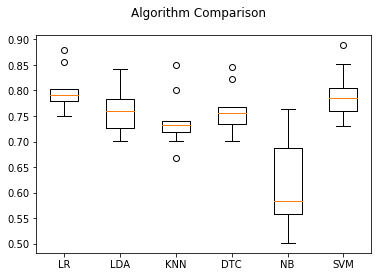

In [62]:
# Compare different models performance on data set

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
    

X = df_listings_scaled.iloc[:, :-1]
y = df_listings_scaled.iloc[:,-1]


# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

* The above box and whisker plot showing the spread of the accuracy scores across each cross validation fold for each algorithm.
* The Plot shows that SVM is the best model in this case.


#### Ques 1: Most important feature affecting rental price ?

No. of Features:  383


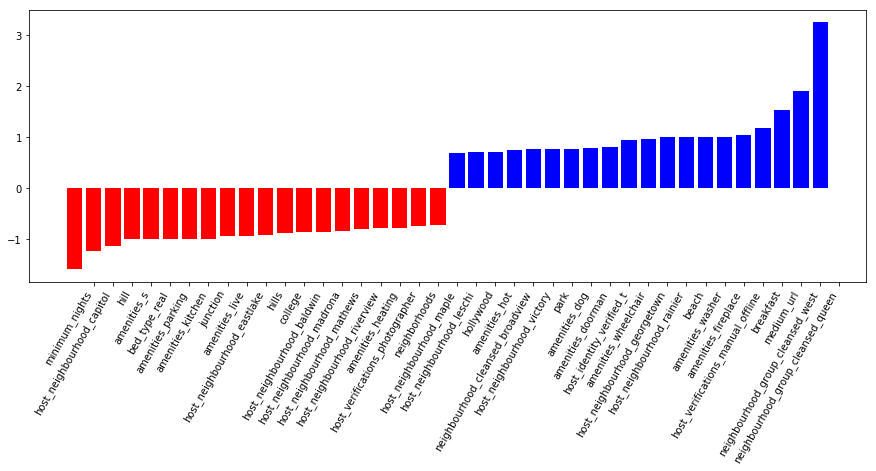

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

cv = CountVectorizer()
cv.fit(df_listings_scaled)
print('No. of Features: ',len(cv.vocabulary_))
#print(cv.get_feature_names())

labels = df_listings_scaled.iloc[:,-1]
train1 = df_listings_scaled.drop('price_label', axis=1)

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train1, labels, test_size = 0.30, random_state = 2)

#X_train = cv.transform(df_listings_scaled)

#svm = LinearSVC()
svm = svm.SVC(kernel='linear')
svm.fit(train1, labels)

plot_coefficients(svm, cv.get_feature_names())

#### Observations

* Neighbourhood is the key feature for rent price.

#### Ques 2: Top three neighbourhoods having highest rental price ?

In [64]:
df_neigh_price = df_listings[['neighbourhood_group_cleansed','price']]
df_neigh_price['price'] = df_neigh_price['price'].apply(lambda p: str(p).replace('$','').replace(',','')).astype(float)
df_neigh_price_grouped = df_neigh_price.groupby('neighbourhood_group_cleansed', as_index=False)['price'].mean()
df_neigh_price_grouped.sort_values('price',ascending=False, inplace=True)


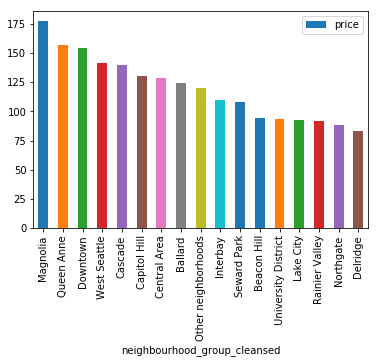

In [65]:
ax = df_neigh_price_grouped.plot.bar(x='neighbourhood_group_cleansed', y='price', rot=90)

#### Observations:

##### Top 3 neighbourhood having highest average price:
* Magnolia: having average price \$176.
* Queen Anne: having average price \$152.
* Downtown: having average price \$151.

#### Ques 3: Top three months having the highest rental price ?

In [66]:
# load clean calendar data set to pickle file
df_calendar_clean = pd.read_pickle('calendar_clean.pkl')

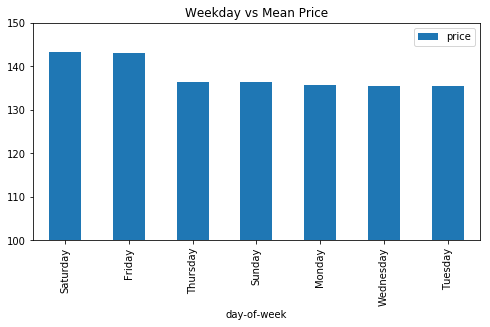

In [67]:
### Weekday vs Mean Price
mean_price_weekday = pd.DataFrame(df_calendar_clean[df_calendar_clean['available'] == True].groupby('day-of-week')['price'].mean())
mean_price_weekday.sort_values(['price'], ascending=False, inplace=True)
ax = mean_price_weekday[['price']].plot(kind='bar', ylim=(100,150),title ="Weekday vs Mean Price", figsize=(8, 4), legend=True, fontsize=10)

#### Observations:

* Mean price for Friday and Saturday are higher than other weekdays.

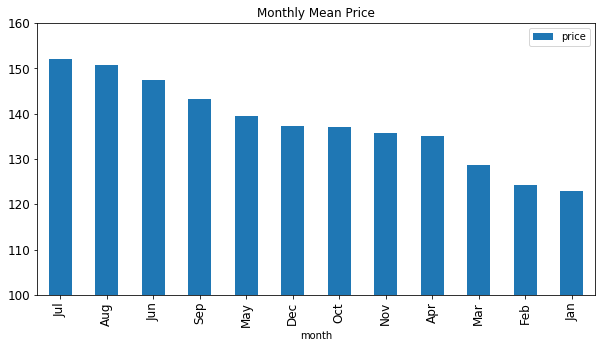

In [68]:
# Mean Price vs Month
mean_price_month = pd.DataFrame(df_calendar_clean[df_calendar_clean['available'] == True].groupby('month')['price'].mean())
mean_price_month.sort_values(['price'], ascending=False, inplace=True)
ax = mean_price_month[['price']].plot(kind='bar', ylim=(100,160),title ="Monthly Mean Price", figsize=(10, 5), legend=True, fontsize=12)

#### Observations:

* The mean price for the months June, July and August are higer than rest of the months.
* January and February and March months are having the lowest mean price.
* The rental prices are higher in Summer season compared to rest of the seasons.
* The rental prices are lower in Winter season (specially in January and February) compared to rest of the seasons.